##1. Notice the problem of SER's robustness in a noisy environment

#### General preparation of the environment


In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()


In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install kaggle


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00


In [ ]:
import time
from tqdm import tqdm
import torch

In [ ]:
import zipfile
import os
import shutil
import random
import numpy as np
from scipy.io import wavfile
from scipy.signal import resample
import torchaudio
import torchaudio.functional as F
import torch
import torchaudio.transforms as T
import soundfile as sf
import pandas as pd
import seaborn as sns
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

#### 1.Import the DEMAND Dataset from kaggle

In [ ]:
!kaggle datasets download -d chrisfilo/demand



Dataset URL: https://www.kaggle.com/datasets/chrisfilo/demand
License(s): Attribution 4.0 International (CC BY 4.0)
100% 6.86G/6.87G [00:52<00:00, 130MB/s]
100% 6.87G/6.87G [00:52<00:00, 142MB/s]


In [ ]:

# Path to dataset zip file
zip_file_path = '/content/demand.zip'

# Destination folder where you want to extract the files
extracted_folder = '/content/demand'

# Create a folder to extract files into
os.makedirs(extracted_folder, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# List all extracted files
extracted_files = os.listdir(extracted_folder)

# Move all files to a single folder
destination_folder = '/content/demand_dataset'
os.makedirs(destination_folder, exist_ok=True)

for file in extracted_files:
    # Source path of the file
    source_path = os.path.join(extracted_folder, file)
    # Destination path where the file will be moved
    destination_path = os.path.join(destination_folder, file)
    # Move the file to the destination folder
    shutil.move(source_path, destination_path)

# Optionally, remove the extracted folder
shutil.rmtree(extracted_folder)

print("All files have been extracted and moved to one folder.")


All files have been extracted and moved to one folder.


#### 2.Import RAVDESS Dataset from Kaggle

In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 95% 408M/429M [00:02<00:00, 258MB/s]
100% 429M/429M [00:02<00:00, 206MB/s]


In [ ]:

# Path to your dataset zip file
zip_file_path = '/content/ravdess-emotional-speech-audio.zip'

# Destination folder where you want to extract the files
extracted_folder = '/content/ravdess'

# Create a folder to extract files into
os.makedirs(extracted_folder, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# List all extracted files
extracted_files = os.listdir(extracted_folder)

# Move all files to a single folder
destination_folder = '/content/ravdess_dataset'
os.makedirs(destination_folder, exist_ok=True)

for file in extracted_files:
    # Source path of the file
    source_path = os.path.join(extracted_folder, file)
    # Destination path where the file will be moved
    destination_path = os.path.join(destination_folder, file)
    # Move the file to the destination folder
    shutil.move(source_path, destination_path)

# Optionally, remove the extracted folder
shutil.rmtree(extracted_folder)

print("All files have been extracted and moved to one folder.")


All files have been extracted and moved to one folder.


#### 3.Generate noisy dataset

Now we need to generate the noisy dataset , to do we will create a function that mix the two audios and the iterate in a loop to create the noised dataset

In [ ]:

def mix_wav_files(wav_file1, wav_file2, output_file, snr):
    # WAV files
    rate1, data1 = wavfile.read(wav_file1)
    rate2, data2 = wavfile.read(wav_file2)

    #Resampling for 16k

    #data1 = resample(data1, 16000)
    #data2 = resample(data2, 16000)

    # Randomly select segment from longer audio file; generally the audio from demand
    min_length = min(len(data1), len(data2))
    max_length = max(len(data1), len(data2))
    if len(data1) == max_length:
        start_idx = random.randint(0, max_length - min_length)
        data1 = data1[start_idx:start_idx+min_length]
    else:
        start_idx = random.randint(0, max_length - min_length)
        data2 = data2[start_idx:start_idx+min_length]

    # while running the code before adding this part, we get sometimes an error on the difference of dimension of the audios
    # Check if data2 is stereo, and convert data1 to stereo if needed
    if data2.ndim == 2 and data1.ndim == 1:
        data1 = np.column_stack((data1, data1))  # Duplicate mono audio to make it stereo

    # Check if data1 is stereo, and convert data2 to stereo if needed
    if data1.ndim == 2 and data2.ndim == 1:
        data2 = np.column_stack((data2, data2))  # Duplicate mono audio to make it stereo

    # Calculate scaling factor for SNR
    rms_signal = np.sqrt(np.mean(data1**2))
    rms_noise = rms_signal / (10**(snr / 20.0))

    # Adjust amplitude of noise
    scaled_noise = data2 * (rms_noise / np.sqrt(np.mean(data2**2)))


    # Mix signals
    mixed_data = data1 + scaled_noise
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    # Save
    wavfile.write(output_file, rate1, mixed_data.astype(np.int16))






In [ ]:

def signal_noise_mix (signal_path, noise_path, snr_list):
  speech, original_sample_rate = torchaudio.load(signal_path)
  #resample ravdess to 16k
  resampler = T.Resample(original_sample_rate, 16000, dtype=speech.dtype)
  resampled_speech = resampler(speech)
  noise, _ = torchaudio.load(noise_path)
  print(noise.shape)
  #cut noise to match shape of clean speech
  noise = noise[:, : resampled_speech.shape[1]]
  #mixing
  noisy_speeches = F.add_noise(resampled_speech, noise, snr_list)
  return noisy_speeches


In [ ]:

# loop for creating the noised dataset

clean_dataset = "/content/ravdess_dataset"
noise_dataset = "/content/demand_dataset"
output_path = "/content/noised_dataset"

# exclude the last file !
folders_clean_dataset = sorted(os.listdir(clean_dataset))[:-1]  # take only the fifth last actors #[-6:-1]

# Create the empty dataframe
data = []

#SNR values
snr_values = [ -5 , -2 ,-1, 0, 5, 10, 15, 30 ]
#snr_values = [ -5 , 0, 5, 10]

#fix the seed
random.seed(4)

# we will only choose some kind of noises not all of them, the domestik ones
noises= ['OMEETING_16k', 'OHALLWAY_16k', 'DKITCHEN_16k','OOFFICE_16k', 'DLIVING_16k','PCAFETER_16k']
#noises= ['DKITCHEN_48k','DLIVING_48k','DWASHING_48k']

# iterate for each snr
for snr in snr_values:
  # for each noise
  for noise in noises:
    snr_output_folder = os.path.join(output_path, "SNR_" + str(snr))
    print(snr_output_folder)
    noise_output_folder = os.path.join(snr_output_folder, str(noise))
    print(noise_output_folder)
    for folder in folders_clean_dataset:
      folder_path = os.path.join(clean_dataset, folder)
      print(folder)
      print(folder_path)

      # extarct the wave files
      wav_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

      # for each actor we will create a folder
      output_folder = os.path.join(noise_output_folder, folder)
      print(output_folder)
      #make sure that it exist
      os.makedirs(output_folder, exist_ok=True)
      # now we will iterate on the waves files
      for wav_file in wav_files:
        noise_folder_path = os.path.join(noise_dataset, noise)
        #choose the first folder from the random folder  # when i dizipped that's I get
        first_noise_folder_path = [sorted(os.listdir(noise_folder_path))[0]]
        noise_type=first_noise_folder_path[0]
        #print(first_noise_folder_path)

        # Iterate for each noise in the noise folder
        for file in first_noise_folder_path:
           # define the input file  and the output one
           input_file = os.path.join(folder_path, wav_file)

           wav_file_dir = os.path.join(noise_folder_path, file)
           print(wav_file_dir)

           output_file = os.path.join(output_folder, wav_file)
           print(output_file)

           wav_file2_noise = random.choice(os.listdir(wav_file_dir))
           print(wav_file2_noise)
           wav_file2 = os.path.join(wav_file_dir,wav_file2_noise)
           print(wav_file2)
           mix_wav_files(input_file, wav_file2, output_file, snr)
            # add to the dataframe
           data.append({'SNR': snr, 'Actor': folder , 'Input_clean_file': input_file , 'Input_noise_file': wav_file2 ,'Noise': wav_file2_noise ,'Noise_type': noise_type, 'Output_file':output_file})


df = pd.DataFrame(data)
df.to_csv('/content/dataframe.csv', index=True)

/content/noised_dataset/SNR_-5
/content/noised_dataset/SNR_-5/DKITCHEN_48k
Actor_01
/content/ravdess_dataset/Actor_01
/content/noised_dataset/SNR_-5/DKITCHEN_48k/Actor_01
/content/demand_dataset/DKITCHEN_48k/DKITCHEN
/content/noised_dataset/SNR_-5/DKITCHEN_48k/Actor_01/03-01-08-01-02-01-01.wav
ch15.wav
/content/demand_dataset/DKITCHEN_48k/DKITCHEN/ch15.wav
/content/demand_dataset/DKITCHEN_48k/DKITCHEN
/content/noised_dataset/SNR_-5/DKITCHEN_48k/Actor_01/03-01-06-02-01-01-01.wav
ch11.wav
/content/demand_dataset/DKITCHEN_48k/DKITCHEN/ch11.wav
/content/demand_dataset/DKITCHEN_48k/DKITCHEN
/content/noised_dataset/SNR_-5/DKITCHEN_48k/Actor_01/03-01-03-02-01-01-01.wav
ch12.wav
/content/demand_dataset/DKITCHEN_48k/DKITCHEN/ch12.wav
/content/demand_dataset/DKITCHEN_48k/DKITCHEN
/content/noised_dataset/SNR_-5/DKITCHEN_48k/Actor_01/03-01-05-01-02-01-01.wav
ch02.wav
/content/demand_dataset/DKITCHEN_48k/DKITCHEN/ch02.wav
/content/demand_dataset/DKITCHEN_48k/DKITCHEN
/content/noised_dataset/SNR_-5/

<ipython-input-8-49977b1e03e6>:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate1, data1 = wavfile.read(wav_file1)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/content/demand_dataset/DWASHING_48k/DWASHING
/content/noised_dataset/SNR_30/DWASHING_48k/Actor_04/03-01-06-02-01-02-04.wav
ch12.wav
/content/demand_dataset/DWASHING_48k/DWASHING/ch12.wav
/content/demand_dataset/DWASHING_48k/DWASHING
/content/noised_dataset/SNR_30/DWASHING_48k/Actor_04/03-01-05-01-01-02-04.wav
ch09.wav
/content/demand_dataset/DWASHING_48k/DWASHING/ch09.wav
/content/demand_dataset/DWASHING_48k/DWASHING
/content/noised_dataset/SNR_30/DWASHING_48k/Actor_04/03-01-06-02-02-02-04.wav
ch04.wav
/content/demand_dataset/DWASHING_48k/DWASHING/ch04.wav
/content/demand_dataset/DWASHING_48k/DWASHING
/content/noised_dataset/SNR_30/DWASHING_48k/Actor_04/03-01-08-01-01-01-04.wav
ch01.wav
/content/demand_dataset/DWASHING_48k/DWASHING/ch01.wav
/content/demand_dataset/DWASHING_48k/DWASHING
/content/noised_dataset/SNR_30/DWASHING_48k/Actor_04/03-01-04-01-01-01-04.wav
ch06.wav
/content/demand_dataset/DWASHING_48k/

In [ ]:
display(df)

SNR     Actor                                   Input_clean_file  \
0       -5  Actor_01  /content/ravdess_dataset/Actor_01/03-01-08-01-...   
1       -5  Actor_01  /content/ravdess_dataset/Actor_01/03-01-06-02-...   
2       -5  Actor_01  /content/ravdess_dataset/Actor_01/03-01-03-02-...   
3       -5  Actor_01  /content/ravdess_dataset/Actor_01/03-01-05-01-...   
4       -5  Actor_01  /content/ravdess_dataset/Actor_01/03-01-04-02-...   
...    ...       ...                                                ...   
34555   30  Actor_24  /content/ravdess_dataset/Actor_24/03-01-02-02-...   
34556   30  Actor_24  /content/ravdess_dataset/Actor_24/03-01-08-01-...   
34557   30  Actor_24  /content/ravdess_dataset/Actor_24/03-01-07-02-...   
34558   30  Actor_24  /content/ravdess_dataset/Actor_24/03-01-06-01-...   
34559   30  Actor_24  /content/ravdess_dataset/Actor_24/03-01-06-02-...   

                                        Input_noise_file     Noise Noise_type  \
0      /content/demand_dataset/DKITCHEN_48k/DKITCHEN/...  ch15.wav   DKITCHEN   
1      /content/demand_dataset/DKITCHEN_48k/DKITCHEN/...  ch11.wav   DKITCHEN   
2      /content/demand_dataset/DKITCHEN_48k/DKITCHEN/...  ch12.wav   DKITCHEN   
3      /content/demand_dataset/DKITCHEN_48k/DKITCHEN/...  ch02.wav   DKITCHEN   
4      /content/demand_dataset/DKITCHEN_48k/DKITCHEN/...  ch07.wav   DKITCHEN   
...                                                  ...       ...        ...   
34555  /content/demand_dataset/DWASHING_48k/DWASHING/...  ch13.wav   DWASHING   
34556  /content/demand_dataset/DWASHING_48k/DWASHING/...  ch08.wav   DWASHING   
34557  /content/demand_dataset/DWASHING_48k/DWASHING/...  ch10.wav   DWASHING   
34558  /content/demand_dataset/DWASHING_48k/DWASHING/...  ch14.wav   DWASHING   
34559  /content/demand_dataset/DWASHING_48k/DWASHING/...  ch14.wav   DWASHING   

                                             Output_file  
0      /content/noised_dataset/SNR_-5/DKITCHEN_48k/Ac...  
1      /content/noised_dataset/SNR_-5/DKITCHEN_48k/Ac...  
2      /content/noised_dataset/SNR_-5/DKITCHEN_48k/Ac...  
3      /content/noised_dataset/SNR_-5/DKITCHEN_48k/Ac...  
4      /content/noised_dataset/SNR_-5/DKITCHEN_48k/Ac...  
...                                                  ...  
34555  /content/noised_dataset/SNR_30/DWASHING_48k/Ac...  
34556  /content/noised_dataset/SNR_30/DWASHING_48k/Ac...  
34557  /content/noised_dataset/SNR_30/DWASHING_48k/Ac...  
34558  /content/noised_dataset/SNR_30/DWASHING_48k/Ac...  
34559  /content/noised_dataset/SNR_30/DWASHING_48k/Ac...  

[34560 rows x 7 columns]

Now let's test and display the same audio from ravdess and noised dataset

#### 4. inference for the fine-tuned model (Marwa) --> Accuracy decreasing

## 2. Impelement a Robust SER





#### Data Augmentataion


###### 1. Data processing

Dataframe for the clean RAVDESS dataset

In [ ]:
import os
import pandas as pd

RAV = "/content/ravdess_dataset/"
dir_list = os.listdir(RAV)
dir_list.sort()
dir_list.pop()
emotion = []
gender = []
Actor = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    #print('fnmae' ,fname)
    for f in fname:
       # print(f)
        part = f.split('.')[0].split('-')
        #print(part)
        emotion_ = int(part[2])
        print(emotion_)
        emotion.append(emotion_)
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        Actor.append(int(i.split('_')[1]))
        path.append(RAV + i + '/' + f)

RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df, pd.DataFrame(emotion)],axis=1)
RAV_df.columns = ['gender','emotion','labels']
RAV_df['source'] = 'RAVDESS'
#RAV_df['Actor'] =  Actor
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df.emotion.value_counts()

8
6
3
5
4
7
3
7
8
7
3
6
5
2
2
2
3
6
2
2
8
4
4
4
2
5
8
5
6
2
8
8
3
4
2
4
7
4
6
5
1
6
6
1
8
6
1
4
5
8
1
7
3
7
7
3
5
7
3
5
6
2
3
7
5
1
2
3
2
8
5
6
7
8
4
2
5
2
2
4
5
5
6
4
4
8
2
3
3
7
3
7
1
4
4
6
6
7
3
1
7
4
5
5
1
8
7
4
5
8
3
6
8
6
3
8
7
6
8
2
2
5
8
3
7
4
2
7
5
3
3
6
8
2
8
7
7
6
2
7
5
2
3
1
5
5
4
4
8
4
3
3
6
5
6
1
1
8
4
6
4
6
2
5
5
4
7
8
3
7
7
1
8
6
6
4
2
2
8
3
5
4
3
2
2
5
8
1
8
6
8
4
3
3
6
3
7
3
2
7
2
1
4
8
8
6
5
6
8
4
7
1
7
3
3
7
2
7
5
5
6
4
2
7
2
4
6
4
3
8
8
6
2
5
7
1
6
5
4
5
4
1
7
5
7
2
5
2
4
4
8
3
6
3
6
8
8
4
8
3
4
2
2
6
8
7
7
7
5
6
8
7
3
2
4
6
6
3
5
5
7
8
3
1
1
3
2
4
7
2
5
2
5
3
4
6
1
6
5
8
1
2
3
7
8
5
5
3
2
8
8
7
4
6
1
6
7
6
5
3
5
3
8
6
1
4
4
2
5
1
6
2
3
5
4
3
8
8
2
6
2
6
7
5
6
2
4
3
7
7
7
8
5
8
4
3
4
7
4
2
8
7
3
6
6
5
2
1
6
2
7
2
6
1
3
2
4
2
5
3
7
5
8
5
6
2
4
3
8
4
8
7
8
2
4
7
6
7
3
8
6
6
3
1
2
5
5
7
4
1
7
4
5
4
5
8
3
4
8
3
5
4
8
4
6
7
6
2
7
3
5
4
4
6
8
3
2
7
3
5
8
1
7
1
5
8
4
5
8
8
2
3
1
1
7
7
3
3
4
4
7
5
4
6
6
5
3
7
6
2
5
2
8
6
8
2
2
2
6
3
8
3
8
7
5
5
4
2
3
6
1
8
8
7
4
3
1
7
2
4


emotion
neutral     288
surprise    192
fear        192
happy       192
angry       192
sad         192
disgust     192
Name: count, dtype: int64

In [ ]:
RAV_df

gender   emotion  labels   source  \
0       male  surprise       8  RAVDESS   
1       male      fear       6  RAVDESS   
2       male     happy       3  RAVDESS   
3       male     angry       5  RAVDESS   
4       male       sad       4  RAVDESS   
...      ...       ...     ...      ...   
1435  female   neutral       2  RAVDESS   
1436  female  surprise       8  RAVDESS   
1437  female   disgust       7  RAVDESS   
1438  female      fear       6  RAVDESS   
1439  female      fear       6  RAVDESS   

                                                   path  
0     /content/ravdess_dataset/Actor_01/03-01-08-01-...  
1     /content/ravdess_dataset/Actor_01/03-01-06-02-...  
2     /content/ravdess_dataset/Actor_01/03-01-03-02-...  
3     /content/ravdess_dataset/Actor_01/03-01-05-01-...  
4     /content/ravdess_dataset/Actor_01/03-01-04-02-...  
...                                                 ...  
1435  /content/ravdess_dataset/Actor_24/03-01-02-02-...  
1436  /content/ravdess_dataset/Actor_24/03-01-08-01-...  
1437  /content/ravdess_dataset/Actor_24/03-01-07-02-...  
1438  /content/ravdess_dataset/Actor_24/03-01-06-01-...  
1439  /content/ravdess_dataset/Actor_24/03-01-06-02-...  

[1440 rows x 5 columns]

Dataframe for the noised RAVDESS dataset

In [ ]:
noised_RAV = "/content/noised_dataset/"
snr_dir_list = os.listdir(noised_RAV)
dir_list = os.listdir(RAV)
dir_list.sort()
dir_list.pop()
SNR = []
Actor = []
Noise = []
emotion = []
gender = []
path = []
for snr_dir in snr_dir_list:
  #print(snr_dir_list)
  noise_snr_dir_list= os.listdir(noised_RAV + snr_dir)
  #print(noise_snr_dir_list)
  for noise_dir in noise_snr_dir_list:
    actor_dir = os.listdir(noised_RAV + snr_dir + '/'+ noise_dir)
    for actor in actor_dir:
      fname = os.listdir(noised_RAV + snr_dir + '/'+ noise_dir +'/'+ actor)
      for f in fname:
         #print(fname)
         part = f.split('.')[0].split('-')
         emotion.append(int(part[2]))
         temp = int(part[6])
         if temp%2 == 0:
            temp = "female"
         else:
            temp = "male"
         SNR.append(str(snr_dir.split('_')[1]))
         Noise.append(str(noise_dir.split('_')[0]))
         gender.append(temp)
         Actor.append(int(actor.split('_')[1]))
         path.append(noised_RAV + snr_dir + '/'+ noise_dir +'/'+ actor + '/' + f)



noised_RAV_df = pd.DataFrame({
    "gender": gender,
    "emotion": emotion,
    "SNR": SNR,
    "Noise": Noise,
    "path": path
})


# Map emotion labels to corresponding emotions
emotion_labels = {
    1: 'neutral',
    2: 'neutral',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}

# Add a new column for emotion labels
noised_RAV_df['labels'] = noised_RAV_df['emotion']

# Replace emotion codes with corresponding labels
noised_RAV_df['emotion'] = noised_RAV_df['emotion'].replace(emotion_labels)
noised_RAV_df['source'] = 'Noised_RAVDESS'

# Affichage des comptages des émotions
print(noised_RAV_df['emotion'].value_counts())





emotion
neutral     6912
fear        4608
happy       4608
disgust     4608
angry       4608
surprise    4608
sad         4608
Name: count, dtype: int64


In [ ]:
RAV_df

gender   emotion  labels   source  \
0       male  surprise       8  RAVDESS   
1       male      fear       6  RAVDESS   
2       male     happy       3  RAVDESS   
3       male     angry       5  RAVDESS   
4       male       sad       4  RAVDESS   
...      ...       ...     ...      ...   
1435  female   neutral       2  RAVDESS   
1436  female  surprise       8  RAVDESS   
1437  female   disgust       7  RAVDESS   
1438  female      fear       6  RAVDESS   
1439  female      fear       6  RAVDESS   

                                                   path  
0     /content/ravdess_dataset/Actor_01/03-01-08-01-...  
1     /content/ravdess_dataset/Actor_01/03-01-06-02-...  
2     /content/ravdess_dataset/Actor_01/03-01-03-02-...  
3     /content/ravdess_dataset/Actor_01/03-01-05-01-...  
4     /content/ravdess_dataset/Actor_01/03-01-04-02-...  
...                                                 ...  
1435  /content/ravdess_dataset/Actor_24/03-01-02-02-...  
1436  /content/ravdess_dataset/Actor_24/03-01-08-01-...  
1437  /content/ravdess_dataset/Actor_24/03-01-07-02-...  
1438  /content/ravdess_dataset/Actor_24/03-01-06-01-...  
1439  /content/ravdess_dataset/Actor_24/03-01-06-02-...  

[1440 rows x 5 columns]

In [ ]:
noised_RAV_df

gender   emotion SNR     Noise  \
0      female      fear   5  DKITCHEN   
1      female   neutral   5  DKITCHEN   
2      female     happy   5  DKITCHEN   
3      female   disgust   5  DKITCHEN   
4      female     angry   5  DKITCHEN   
...       ...       ...  ..       ...   
34555    male  surprise   0   DLIVING   
34556    male     happy   0   DLIVING   
34557    male       sad   0   DLIVING   
34558    male  surprise   0   DLIVING   
34559    male     happy   0   DLIVING   

                                                    path  labels  \
0      /content/noised_dataset/SNR_5/DKITCHEN_48k/Act...       6   
1      /content/noised_dataset/SNR_5/DKITCHEN_48k/Act...       2   
2      /content/noised_dataset/SNR_5/DKITCHEN_48k/Act...       3   
3      /content/noised_dataset/SNR_5/DKITCHEN_48k/Act...       7   
4      /content/noised_dataset/SNR_5/DKITCHEN_48k/Act...       5   
...                                                  ...     ...   
34555  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...       8   
34556  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...       3   
34557  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...       4   
34558  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...       8   
34559  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...       3   

               source  
0      Noised_RAVDESS  
1      Noised_RAVDESS  
2      Noised_RAVDESS  
3      Noised_RAVDESS  
4      Noised_RAVDESS  
...               ...  
34555  Noised_RAVDESS  
34556  Noised_RAVDESS  
34557  Noised_RAVDESS  
34558  Noised_RAVDESS  
34559  Noised_RAVDESS  

[34560 rows x 7 columns]

In [ ]:
RAV_df = RAV_df[(RAV_df["emotion"]=="neutral") | (RAV_df["emotion"]=="happy") | (RAV_df["emotion"]=="sad") | (RAV_df["emotion"]=="angry")]
noised_RAV_df = noised_RAV_df[(noised_RAV_df["emotion"]=="neutral") | (noised_RAV_df["emotion"]=="happy") | (noised_RAV_df["emotion"]=="sad") | (noised_RAV_df["emotion"]=="angry")]

In [ ]:
RAV_df.emotion.value_counts()


emotion
neutral    288
happy      192
angry      192
sad        192
Name: count, dtype: int64

In [ ]:
noised_RAV_df.emotion.value_counts()

emotion
neutral    6912
happy      4608
angry      4608
sad        4608
Name: count, dtype: int64

Now let's merge both of the dataframes that we have in order to define the train and the test datasets


In [ ]:
# add the two columns for the clean dataset
RAV_df['Noise']='clean'
RAV_df['SNR'] = 'inf'
display(RAV_df)

#Now we will merge both of datasets
merged_RAV_df = pd.concat([RAV_df, noised_RAV_df], ignore_index=True)
display(merged_RAV_df)

<ipython-input-21-59c8c6ec6826>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RAV_df['Noise']='clean'
<ipython-input-21-59c8c6ec6826>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RAV_df['SNR'] = 'inf'


gender  emotion  labels   source  \
2       male    happy       3  RAVDESS   
3       male    angry       5  RAVDESS   
4       male      sad       4  RAVDESS   
6       male    happy       3  RAVDESS   
10      male    happy       3  RAVDESS   
...      ...      ...     ...      ...   
1431  female      sad       4  RAVDESS   
1432  female    happy       3  RAVDESS   
1433  female  neutral       2  RAVDESS   
1434  female    angry       5  RAVDESS   
1435  female  neutral       2  RAVDESS   

                                                   path  Noise  SNR  
2     /content/ravdess_dataset/Actor_01/03-01-03-02-...  clean  inf  
3     /content/ravdess_dataset/Actor_01/03-01-05-01-...  clean  inf  
4     /content/ravdess_dataset/Actor_01/03-01-04-02-...  clean  inf  
6     /content/ravdess_dataset/Actor_01/03-01-03-01-...  clean  inf  
10    /content/ravdess_dataset/Actor_01/03-01-03-02-...  clean  inf  
...                                                 ...    ...  ...  
1431  /content/ravdess_dataset/Actor_24/03-01-04-02-...  clean  inf  
1432  /content/ravdess_dataset/Actor_24/03-01-03-02-...  clean  inf  
1433  /content/ravdess_dataset/Actor_24/03-01-02-01-...  clean  inf  
1434  /content/ravdess_dataset/Actor_24/03-01-05-02-...  clean  inf  
1435  /content/ravdess_dataset/Actor_24/03-01-02-02-...  clean  inf  

[864 rows x 7 columns]

gender emotion  labels          source  \
0       male   happy       3         RAVDESS   
1       male   angry       5         RAVDESS   
2       male     sad       4         RAVDESS   
3       male   happy       3         RAVDESS   
4       male   happy       3         RAVDESS   
...      ...     ...     ...             ...   
21595   male     sad       4  Noised_RAVDESS   
21596   male   angry       5  Noised_RAVDESS   
21597   male   happy       3  Noised_RAVDESS   
21598   male     sad       4  Noised_RAVDESS   
21599   male   happy       3  Noised_RAVDESS   

                                                    path    Noise  SNR  
0      /content/ravdess_dataset/Actor_01/03-01-03-02-...    clean  inf  
1      /content/ravdess_dataset/Actor_01/03-01-05-01-...    clean  inf  
2      /content/ravdess_dataset/Actor_01/03-01-04-02-...    clean  inf  
3      /content/ravdess_dataset/Actor_01/03-01-03-01-...    clean  inf  
4      /content/ravdess_dataset/Actor_01/03-01-03-02-...    clean  inf  
...                                                  ...      ...  ...  
21595  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...  DLIVING    0  
21596  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...  DLIVING    0  
21597  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...  DLIVING    0  
21598  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...  DLIVING    0  
21599  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...  DLIVING    0  

[21600 rows x 7 columns]

<ipython-input-22-08a07db25432>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_RAV_df , x='SNR', palette='Blues')


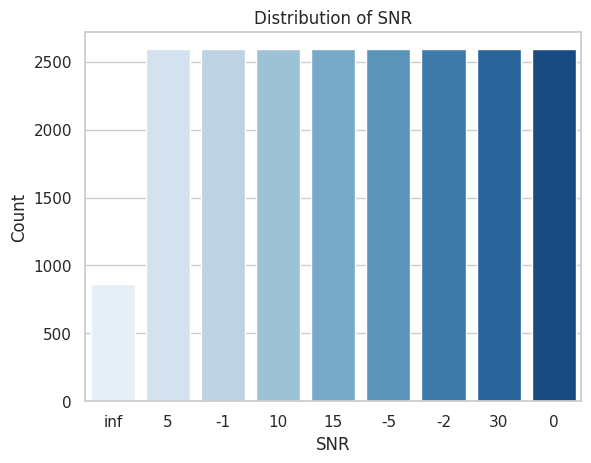

<ipython-input-22-08a07db25432>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_RAV_df , x='Noise', palette='Blues')


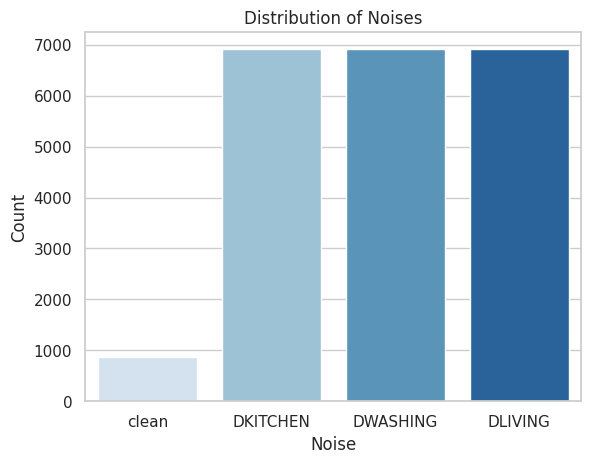

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set the style of the visualization
sns.set(style="whitegrid")

# Plot for SNR distribution
plt.figure()
sns.countplot(data=merged_RAV_df , x='SNR', palette='Blues')
plt.title('Distribution of SNR')
plt.xlabel('SNR')
plt.ylabel('Count')
plt.savefig('snr_merged.png')
plt.show()





# Plot for Noises distribution
plt.figure()
sns.countplot(data=merged_RAV_df , x='Noise', palette='Blues')
plt.title('Distribution of Noises')
plt.xlabel('Noise')
plt.ylabel('Count')
plt.savefig('noises_merged.png')
plt.show()


In [ ]:
#Using Actor_01 to 19 for train, 20 to 24 for test
# Create train DataFrame for paths containing 'Actor_01' to 'Actor_19'
train_df = merged_RAV_df[merged_RAV_df['path'].str.contains('Actor_0[1-9]|Actor_1[0-9]')]

# Create test DataFrame with the remaining paths
test_df = merged_RAV_df[~merged_RAV_df['path'].str.contains('Actor_0[1-9]|Actor_1[0-9]')]


In [ ]:
merged_RAV_df.SNR.value_counts()

SNR
5      2592
-1     2592
10     2592
15     2592
-5     2592
-2     2592
30     2592
0      2592
inf     864
Name: count, dtype: int64

In [ ]:
merged_RAV_df.Noise.value_counts()

Noise
DKITCHEN    6912
DWASHING    6912
DLIVING     6912
clean        864
Name: count, dtype: int64

In [ ]:
merged_RAV_df.emotion.value_counts()

emotion
neutral    7200
happy      4800
angry      4800
sad        4800
Name: count, dtype: int64

In [ ]:
train_df

gender emotion  labels          source  \
0       male   happy       3         RAVDESS   
1       male   angry       5         RAVDESS   
2       male     sad       4         RAVDESS   
3       male   happy       3         RAVDESS   
4       male   happy       3         RAVDESS   
...      ...     ...     ...             ...   
21595   male     sad       4  Noised_RAVDESS   
21596   male   angry       5  Noised_RAVDESS   
21597   male   happy       3  Noised_RAVDESS   
21598   male     sad       4  Noised_RAVDESS   
21599   male   happy       3  Noised_RAVDESS   

                                                    path    Noise  SNR  
0      /content/ravdess_dataset/Actor_01/03-01-03-02-...    clean  inf  
1      /content/ravdess_dataset/Actor_01/03-01-05-01-...    clean  inf  
2      /content/ravdess_dataset/Actor_01/03-01-04-02-...    clean  inf  
3      /content/ravdess_dataset/Actor_01/03-01-03-01-...    clean  inf  
4      /content/ravdess_dataset/Actor_01/03-01-03-02-...    clean  inf  
...                                                  ...      ...  ...  
21595  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...  DLIVING    0  
21596  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...  DLIVING    0  
21597  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...  DLIVING    0  
21598  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...  DLIVING    0  
21599  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...  DLIVING    0  

[17100 rows x 7 columns]

<ipython-input-28-0e377f1d3071>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='SNR', palette='Blues')


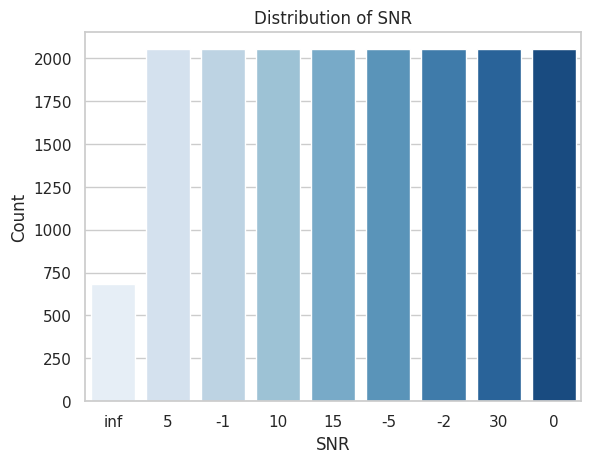

<ipython-input-28-0e377f1d3071>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='emotion', palette='Blues')


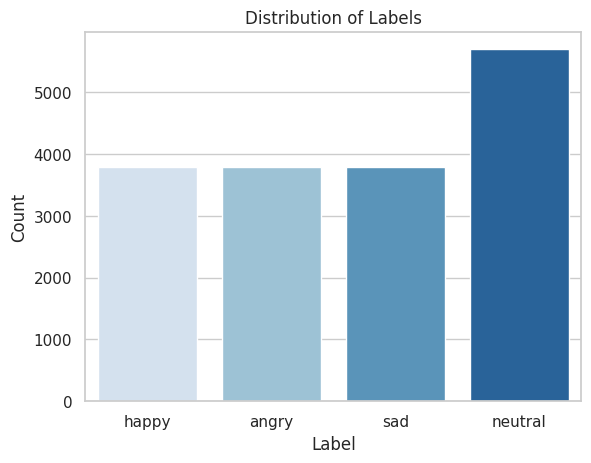

<ipython-input-28-0e377f1d3071>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='gender', palette='Blues')


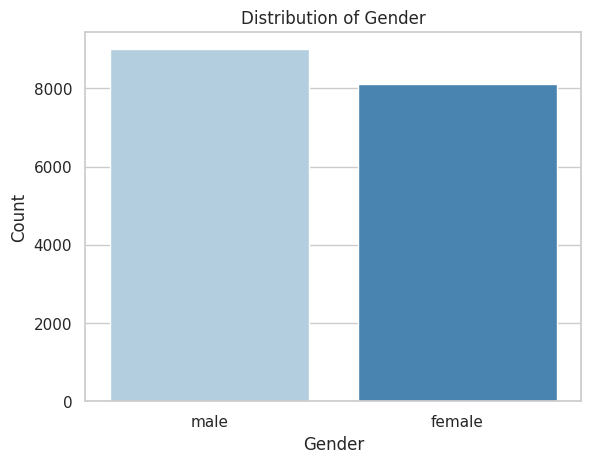

<ipython-input-28-0e377f1d3071>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='Noise', palette='Blues')


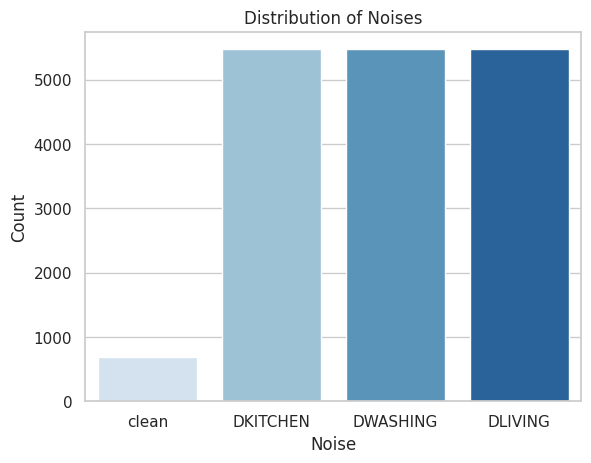

In [ ]:
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Plot for SNR distribution
plt.figure()
sns.countplot(data=train_df, x='SNR', palette='Blues')
plt.title('Distribution of SNR')
plt.xlabel('SNR')
plt.ylabel('Count')
plt.savefig('snr_distribution.png')
plt.show()

# Plot for Labels distribution
plt.figure()
sns.countplot(data=train_df, x='emotion', palette='Blues')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.savefig('labels_distribution.png')
plt.show()

# Plot for Gender distribution
plt.figure()
sns.countplot(data=train_df, x='gender', palette='Blues')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.savefig('gender_distribution.png')
plt.show()

# Plot for Noises distribution
plt.figure()
sns.countplot(data=train_df, x='Noise', palette='Blues')
plt.title('Distribution of Noises')
plt.xlabel('Noise')
plt.ylabel('Count')
plt.savefig('noises_distribution.png')
plt.show()


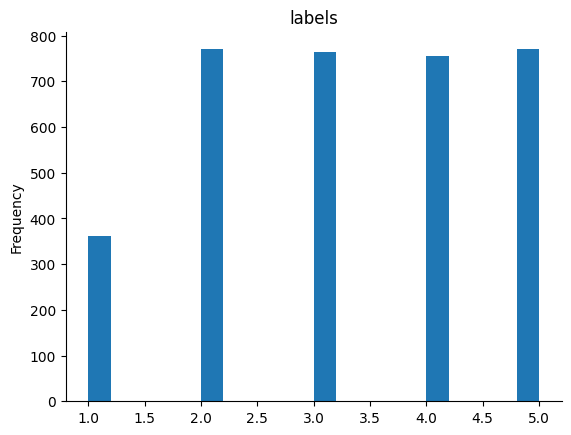

In [ ]:
# @title labels

from matplotlib import pyplot as plt
train_df['labels'].plot(kind='hist', bins=20, title='labels')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
train_df.SNR.value_counts()

SNR
5      2052
-1     2052
10     2052
15     2052
-5     2052
-2     2052
30     2052
0      2052
inf     684
Name: count, dtype: int64

In [ ]:
test_df

gender  emotion  labels          source  \
684    female      sad       4         RAVDESS   
685    female  neutral       2         RAVDESS   
686    female    angry       5         RAVDESS   
687    female      sad       4         RAVDESS   
688    female  neutral       2         RAVDESS   
...       ...      ...     ...             ...   
21559    male      sad       4  Noised_RAVDESS   
21560    male      sad       4  Noised_RAVDESS   
21561    male  neutral       2  Noised_RAVDESS   
21562    male    happy       3  Noised_RAVDESS   
21563    male  neutral       2  Noised_RAVDESS   

                                                    path    Noise  SNR  
684    /content/ravdess_dataset/Actor_20/03-01-04-01-...    clean  inf  
685    /content/ravdess_dataset/Actor_20/03-01-02-02-...    clean  inf  
686    /content/ravdess_dataset/Actor_20/03-01-05-02-...    clean  inf  
687    /content/ravdess_dataset/Actor_20/03-01-04-02-...    clean  inf  
688    /content/ravdess_dataset/Actor_20/03-01-02-02-...    clean  inf  
...                                                  ...      ...  ...  
21559  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...  DLIVING    0  
21560  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...  DLIVING    0  
21561  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...  DLIVING    0  
21562  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...  DLIVING    0  
21563  /content/noised_dataset/SNR_0/DLIVING_48k/Acto...  DLIVING    0  

[4500 rows x 7 columns]

Loading the model Wav2Vec for feature extraction and the optimizer

In [ ]:
#General prep
import time
from tqdm import tqdm
import torch
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
from transformers import HubertForSequenceClassification
import os
import pandas as pd
from datasets import Dataset
import librosa
from torch.utils.data import DataLoader

we will train only for one snr to see how thw accuracy will increase, or we will decrease the amount of the train df


In [ ]:
import pandas as pd

def select_samples(group):
    if len(group) <= 684:
        return group
    else:
        return group.sample(n=684)

# Group the DataFrame by 'SNR' and 'Noise', and apply the function
train_df = train_df.groupby(['SNR']).apply(select_samples).reset_index(drop=True)

# Now df_sampled contains 100 samples for each specific SNR and Noise combination


training on the whole dataset

In [ ]:
train_df

gender  emotion  labels          source  \
0     female  neutral       2  Noised_RAVDESS   
1       male    happy       3  Noised_RAVDESS   
2     female  neutral       1  Noised_RAVDESS   
3     female  neutral       1  Noised_RAVDESS   
4     female      sad       4  Noised_RAVDESS   
...      ...      ...     ...             ...   
6151    male      sad       4         RAVDESS   
6152    male      sad       4         RAVDESS   
6153    male  neutral       1         RAVDESS   
6154    male    angry       5         RAVDESS   
6155    male    happy       3         RAVDESS   

                                                   path     Noise  SNR  
0     /content/noised_dataset/SNR_-1/DKITCHEN_48k/Ac...  DKITCHEN   -1  
1     /content/noised_dataset/SNR_-1/DWASHING_48k/Ac...  DWASHING   -1  
2     /content/noised_dataset/SNR_-1/DKITCHEN_48k/Ac...  DKITCHEN   -1  
3     /content/noised_dataset/SNR_-1/DWASHING_48k/Ac...  DWASHING   -1  
4     /content/noised_dataset/SNR_-1/DKITCHEN_48k/Ac...  DKITCHEN   -1  
...                                                 ...       ...  ...  
6151  /content/ravdess_dataset/Actor_19/03-01-04-01-...     clean  inf  
6152  /content/ravdess_dataset/Actor_19/03-01-04-01-...     clean  inf  
6153  /content/ravdess_dataset/Actor_19/03-01-01-01-...     clean  inf  
6154  /content/ravdess_dataset/Actor_19/03-01-05-02-...     clean  inf  
6155  /content/ravdess_dataset/Actor_19/03-01-03-01-...     clean  inf  

[6156 rows x 7 columns]

<ipython-input-34-0e377f1d3071>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='SNR', palette='Blues')


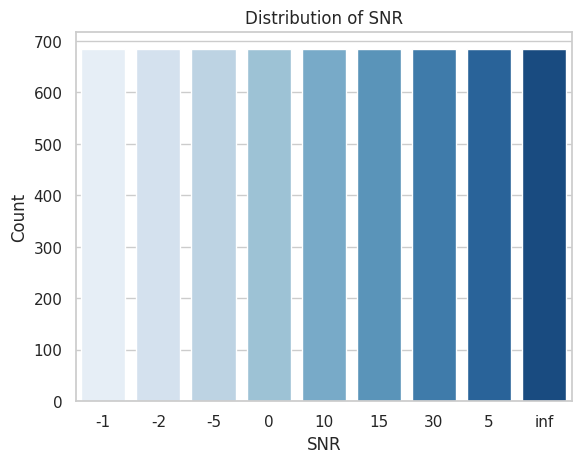

<ipython-input-34-0e377f1d3071>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='emotion', palette='Blues')


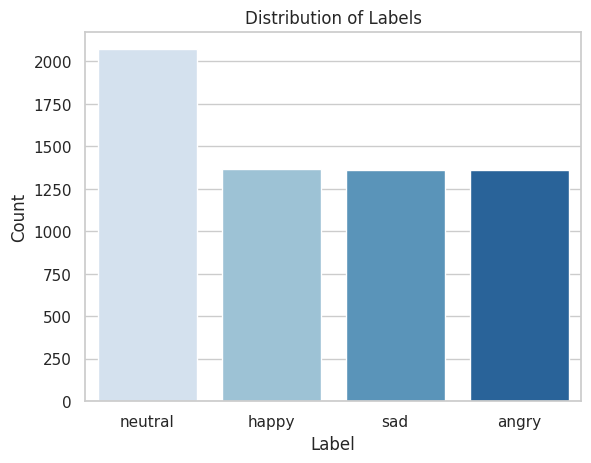

<ipython-input-34-0e377f1d3071>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='gender', palette='Blues')


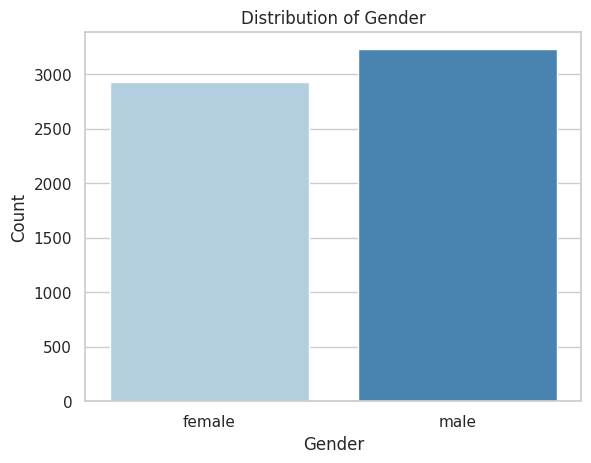

<ipython-input-34-0e377f1d3071>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='Noise', palette='Blues')


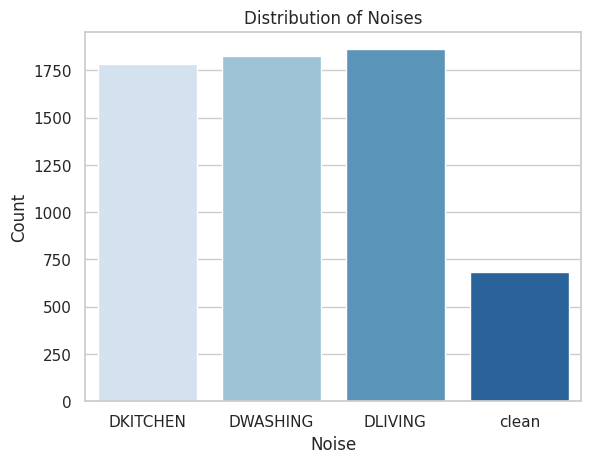

In [ ]:
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Plot for SNR distribution
plt.figure()
sns.countplot(data=train_df, x='SNR', palette='Blues')
plt.title('Distribution of SNR')
plt.xlabel('SNR')
plt.ylabel('Count')
plt.savefig('snr_distribution.png')
plt.show()

# Plot for Labels distribution
plt.figure()
sns.countplot(data=train_df, x='emotion', palette='Blues')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.savefig('labels_distribution.png')
plt.show()

# Plot for Gender distribution
plt.figure()
sns.countplot(data=train_df, x='gender', palette='Blues')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.savefig('gender_distribution.png')
plt.show()

# Plot for Noises distribution
plt.figure()
sns.countplot(data=train_df, x='Noise', palette='Blues')
plt.title('Distribution of Noises')
plt.xlabel('Noise')
plt.ylabel('Count')
plt.savefig('noises_distribution.png')
plt.show()


In [ ]:
train_df.Noise.value_counts()
train_df.SNR.value_counts()


SNR
-1     684
-2     684
-5     684
0      684
10     684
15     684
30     684
5      684
inf    684
Name: count, dtype: int64

In [ ]:
import pandas as pd

def select_samples(group):
    if len(group) <= 100:
        return group
    else:
        return group.sample(n=100)

# Group the DataFrame by 'SNR' and 'Noise', and apply the function
test_df = test_df.groupby(['SNR']).apply(select_samples).reset_index(drop=True)

# Now df_sampled contains 100 samples for each specific SNR and Noise combination


In [ ]:
test_df

gender  emotion  labels          source  \
0    female    happy       3  Noised_RAVDESS   
1    female    angry       5  Noised_RAVDESS   
2    female    happy       3  Noised_RAVDESS   
3    female    angry       5  Noised_RAVDESS   
4    female  neutral       1  Noised_RAVDESS   
..      ...      ...     ...             ...   
895    male      sad       4         RAVDESS   
896    male  neutral       2         RAVDESS   
897    male    angry       5         RAVDESS   
898    male    happy       3         RAVDESS   
899    male  neutral       2         RAVDESS   

                                                  path     Noise  SNR  
0    /content/noised_dataset/SNR_-1/DLIVING_48k/Act...   DLIVING   -1  
1    /content/noised_dataset/SNR_-1/DKITCHEN_48k/Ac...  DKITCHEN   -1  
2    /content/noised_dataset/SNR_-1/DWASHING_48k/Ac...  DWASHING   -1  
3    /content/noised_dataset/SNR_-1/DKITCHEN_48k/Ac...  DKITCHEN   -1  
4    /content/noised_dataset/SNR_-1/DLIVING_48k/Act...   DLIVING   -1  
..                                                 ...       ...  ...  
895  /content/ravdess_dataset/Actor_21/03-01-04-02-...     clean  inf  
896  /content/ravdess_dataset/Actor_23/03-01-02-01-...     clean  inf  
897  /content/ravdess_dataset/Actor_21/03-01-05-02-...     clean  inf  
898  /content/ravdess_dataset/Actor_23/03-01-03-02-...     clean  inf  
899  /content/ravdess_dataset/Actor_21/03-01-02-02-...     clean  inf  

[900 rows x 7 columns]

In [ ]:
noises = train_df['Noise'].unique()
snrs = train_df['path'].unique()
print(noises)
print(snrs)

['DKITCHEN' 'DWASHING' 'DLIVING' 'clean']
['/content/noised_dataset/SNR_-1/DKITCHEN_48k/Actor_18/03-01-02-01-01-01-18.wav'
 '/content/noised_dataset/SNR_-1/DWASHING_48k/Actor_19/03-01-03-02-01-01-19.wav'
 '/content/noised_dataset/SNR_-1/DKITCHEN_48k/Actor_02/03-01-01-01-01-02-02.wav'
 ... '/content/ravdess_dataset/Actor_19/03-01-01-01-01-02-19.wav'
 '/content/ravdess_dataset/Actor_19/03-01-05-02-02-02-19.wav'
 '/content/ravdess_dataset/Actor_19/03-01-03-01-01-01-19.wav']


In [ ]:
if torch.cuda.is_available():
    # Set the device to GPU
    device = torch.device("cuda")
    print("GPU available:", torch.cuda.get_device_name(0))  # Print the GPU name
else:
    print("No GPU available, using CPU instead.")
    device = torch.device("cpu")

GPU available: Tesla T4


In [ ]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Map:   0%|          | 0/6156 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

Create a dataset object

In [ ]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {1:0, 2:0, 3:1, 4:3, 5:2}
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = EmotionDataset(train_encodings, list(train_data["labels"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))

###### 2. Loading the model and the optimizer


In [ ]:
if torch.cuda.is_available():
    # Set the device to GPU
    device = torch.device("cuda")
    print("GPU available:", torch.cuda.get_device_name(0))  # Print the GPU name
else:
    print("No GPU available, using CPU instead.")
    device = torch.device("cpu")

GPU available: Tesla T4


In [ ]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

# Loading the model
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at superb/hubert-large-superb-er were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametri

###### 3. Training loop

In [ ]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [ ]:
# Training

from torch.utils.data import DataLoader

# Set the number of epoch
epoch = 10

# Start training
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

    correct = 0
    count = 0
    epoch_loss = list()

    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()

        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })

        # record the loss for each batch
        epoch_loss.append(loss.item())

    pbar.close()

    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/10


100%|██████████| 3078/3078 [22:28<00:00,  2.28it/s, Loss=0.140, Accuracy=0.751]


Epoch 2/10


100%|██████████| 3078/3078 [22:27<00:00,  2.28it/s, Loss=0.000, Accuracy=0.891]


Epoch 3/10


100%|██████████| 3078/3078 [22:25<00:00,  2.29it/s, Loss=0.012, Accuracy=0.935]


Epoch 4/10


100%|██████████| 3078/3078 [22:27<00:00,  2.28it/s, Loss=0.059, Accuracy=0.958]


Epoch 5/10


100%|██████████| 3078/3078 [22:27<00:00,  2.28it/s, Loss=0.000, Accuracy=0.965]


Epoch 6/10


100%|██████████| 3078/3078 [22:27<00:00,  2.28it/s, Loss=0.000, Accuracy=0.974]


Epoch 7/10


100%|██████████| 3078/3078 [22:25<00:00,  2.29it/s, Loss=0.004, Accuracy=0.975]


Epoch 8/10


 90%|█████████ | 2784/3078 [20:18<02:09,  2.26it/s, Loss=0.022, Accuracy=0.980]

Visualise the training loss and accuracy.

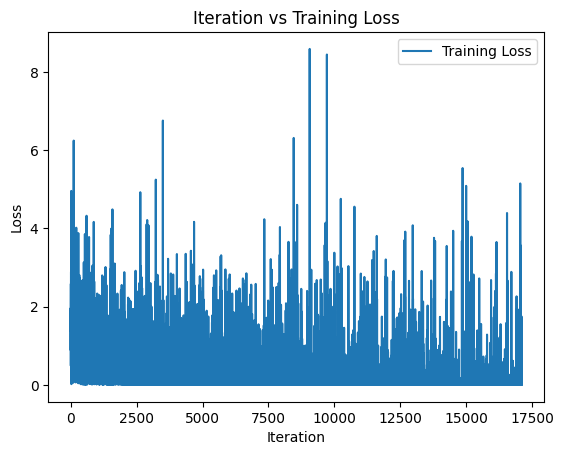

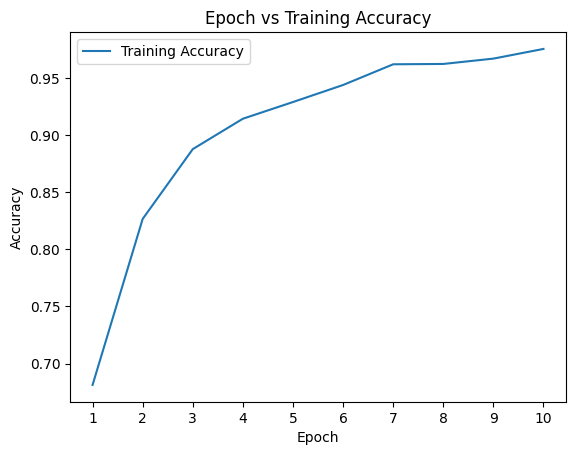

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")
plt.legend()

# Save the plot as a file
plt.savefig('Epoch vs Training Accuracy.png')
plt.show()

###### 4. Testing loop

In [ ]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():

    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}

    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']

        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })

        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()

    pbar.close()

time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 500/500 [00:15<00:00, 31.62it/s, loss=0.000, accuracy=0.858]


The final accuracy on the test dataset: 85.8%


In [ ]:
# Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

def get_emotion(label_id):
    return model.config.id2label[label_id]

df_record["Ground Truth"] = df_record.apply(lambda x: get_emotion(x["Ground Truth"]), axis=1)
df_record["Model Prediction"] = df_record.apply(lambda x: get_emotion(x["Model Prediction"]), axis=1)

# Concat test texts and test records
df = pd.concat([test_df.reset_index(), df_record["Model Prediction"]], axis=1)
df["emotion"] = df.apply(lambda x: x["emotion"][:3], axis=1)

# Show test result
# pd.set_option('display.max_rows', None)    # Display all rows
# df

# Show incorrect predictions
df[df["emotion"]!=df["Model Prediction"]]

index  gender emotion  labels          source  \
6        6    male     sad       4  Noised_RAVDESS   
7        7    male     hap       3  Noised_RAVDESS   
12      12    male     sad       4  Noised_RAVDESS   
20      20    male     sad       4  Noised_RAVDESS   
22      22    male     ang       5  Noised_RAVDESS   
..     ...     ...     ...     ...             ...   
447    447    male     hap       3         RAVDESS   
459    459  female     sad       4         RAVDESS   
475    475  female     sad       4         RAVDESS   
482    482  female     sad       4         RAVDESS   
492    492    male     sad       4         RAVDESS   

                                                  path     Noise  SNR  \
6    /content/noised_dataset/SNR_-5/DWASHING_48k/Ac...  DWASHING   -5   
7    /content/noised_dataset/SNR_-5/DLIVING_48k/Act...   DLIVING   -5   
12   /content/noised_dataset/SNR_-5/DLIVING_48k/Act...   DLIVING   -5   
20   /content/noised_dataset/SNR_-5/DWASHING_48k/Ac...  DWASHING   -5   
22   /content/noised_dataset/SNR_-5/DWASHING_48k/Ac...  DWASHING   -5   
..                                                 ...       ...  ...   
447  /content/ravdess_dataset/Actor_21/03-01-03-01-...     clean  inf   
459  /content/ravdess_dataset/Actor_24/03-01-04-01-...     clean  inf   
475  /content/ravdess_dataset/Actor_24/03-01-04-01-...     clean  inf   
482  /content/ravdess_dataset/Actor_24/03-01-04-01-...     clean  inf   
492  /content/ravdess_dataset/Actor_21/03-01-04-01-...     clean  inf   

    Model Prediction  
6                neu  
7                neu  
12               hap  
20               neu  
22               hap  
..               ...  
447              neu  
459              neu  
475              neu  
482              neu  
492              neu  

[71 rows x 9 columns]

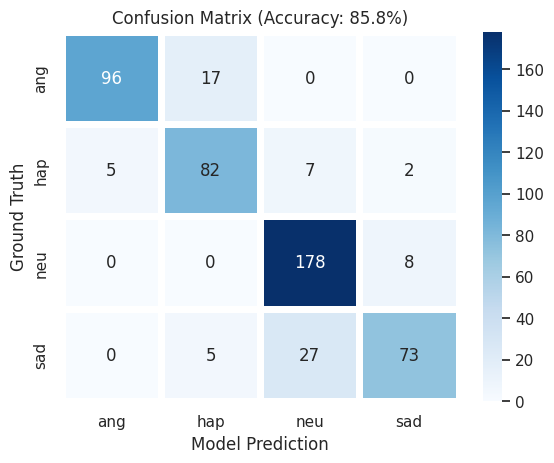

In [ ]:
# Display the Confusion Matrix
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Blues', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.savefig('Confusonmarix.png')
plt.show()

let s see how the model perform for each snr

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# accuracy vs  SNR
accuracy_by_snr = df.groupby('SNR').apply(lambda x: (x['Model Prediction'] == x['emotion']).mean())

# plot accuracy
plt.figure()
plt.plot(accuracy_by_snr.index, accuracy_by_snr.values, marker='o', linestyle='-')
plt.xlabel('SNR')
plt.ylabel('Accuracy')
plt.title('Accuracy vs SNR')
plt.grid(True)
plt.show()


Now let s do the inference with the model fine tunned in clean Ravdess. Before,we should create the same structure od ravdess, so let's create a new dataset or inference

In [ ]:
test_df

gender  emotion  labels          source  \
0    female  neutral       2  Noised_RAVDESS   
1    female    happy       3  Noised_RAVDESS   
2      male  neutral       2  Noised_RAVDESS   
3    female    angry       5  Noised_RAVDESS   
4      male  neutral       1  Noised_RAVDESS   
..      ...      ...     ...             ...   
495  female      sad       4         RAVDESS   
496  female  neutral       1         RAVDESS   
497    male  neutral       1         RAVDESS   
498  female    angry       5         RAVDESS   
499    male    angry       5         RAVDESS   

                                                  path     Noise  SNR  
0    /content/noised_dataset/SNR_-5/DKITCHEN_48k/Ac...  DKITCHEN   -5  
1    /content/noised_dataset/SNR_-5/DLIVING_48k/Act...   DLIVING   -5  
2    /content/noised_dataset/SNR_-5/DLIVING_48k/Act...   DLIVING   -5  
3    /content/noised_dataset/SNR_-5/DKITCHEN_48k/Ac...  DKITCHEN   -5  
4    /content/noised_dataset/SNR_-5/DLIVING_48k/Act...   DLIVING   -5  
..                                                 ...       ...  ...  
495  /content/ravdess_dataset/Actor_22/03-01-04-02-...     clean  inf  
496  /content/ravdess_dataset/Actor_24/03-01-01-01-...     clean  inf  
497  /content/ravdess_dataset/Actor_23/03-01-01-01-...     clean  inf  
498  /content/ravdess_dataset/Actor_22/03-01-05-02-...     clean  inf  
499  /content/ravdess_dataset/Actor_23/03-01-05-02-...     clean  inf  

[500 rows x 7 columns]

In [ ]:
#path to model
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_path = '/content/gdrive/MyDrive/Robust SER/rav_classifier'

In [ ]:
#dataset class
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {1:0, 2:0, 3:1, 4:3, 5:2}
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
#function needed to execute the inference_function
def map_to_array(example):
    speech, _ = librosa.load(example["path"], sr=48000, mono=True)
    example["speech"] = speech
    return example
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [ ]:
#2nd, write a function that does all the preprocessing steps and computes outputs

from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def model_inference(path_to_db, model_path):
  #load the trained model
  model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
  #model.load_state_dict(torch.load(model_path))  #if on gpu uncomment this, comment the line after
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) #if on cpu

  model.to(device)
  RAV = path_to_db
  dir_list = os.listdir(RAV)
  dir_list.sort()
  dir_list.pop()
  emotion = []
  gender = []
  path = []
  for i in dir_list:
      fname = os.listdir(RAV + i)
      for f in fname:
          part = f.split('.')[0].split('-')
          emotion.append(int(part[2]))
          temp = int(part[6])
          if temp%2 == 0:
              temp = "female"
          else:
              temp = "male"
          gender.append(temp)
          path.append(RAV + i + '/' + f)

  RAV_df = pd.DataFrame(emotion)
  RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
  RAV_df = pd.concat([pd.DataFrame(gender), RAV_df, pd.DataFrame(emotion)],axis=1)
  RAV_df.columns = ['gender','emotion','labels']
  RAV_df['source'] = 'RAVDESS'
  RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
  #use only 4 emotions
  RAV_df = RAV_df[(RAV_df["emotion"]=="neutral") | (RAV_df["emotion"]=="happy") | (RAV_df["emotion"]=="sad") | (RAV_df["emotion"]=="angry")]
  #Tokenization
  inference_data = Dataset.from_pandas(RAV_df).map(map_to_array)

  feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

  inference_encodings = feature_extractor(list(inference_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
  #turn data into a dataset object
  inference_dataset = EmotionDataset(inference_encodings, list(inference_data["labels"]))

  #inference
  # Get test data by DataLoader
  inference_loader = DataLoader(inference_dataset, batch_size=1, shuffle=False)

  # Start testing
  model.eval()

  with torch.no_grad():

      correct = 0
      count = 0
      record = {"labels":list(), "predictions":list()}

      pbar = tqdm(inference_loader)
      for batch in pbar:
          input_ids = batch['input_values'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)
          outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs['loss']

          # make predictions
          predictions = predict(outputs)

          # count accuracy
          correct += predictions.eq(labels).sum().item()
          count += len(labels)
          accuracy = correct * 1.0 / count

          # show progress along with metrics
          pbar.set_postfix({
              'loss': '{:.3f}'.format(loss.item()),
              'accuracy': '{:.3f}'.format(accuracy)
          })

          # record the results
          record["labels"] += labels.cpu().numpy().tolist()
          record["predictions"] += predictions.cpu().numpy().tolist()

      pbar.close()


  #print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))
  return round(accuracy*100,4)

In [ ]:
# we want to do the inference for the diffrent SNR and then plot the courve
# Initialize lists to store SNR values and corresponding accuracies
snr_values = [-5,  -1, 0, 5]
accuracies = []
# Perform model inference for each SNR
for snr in snr_values:
    # Construct the path to the dataset for the current SNR
    path_to_db_snr = os.path.join('/content/noised_dataset', f'SNR_{snr}/')

    # Perform model inference for the current SNR
    accuracy = model_inference(path_to_db_snr, '/content/gdrive/MyDrive/Robust SER/rav_classifier')

    # Store the accuracy
    accuracies.append(accuracy)
import matplotlib.pyplot as plt

# Plot SNR vs. accuracy curve
plt.plot(snr_values, accuracies, marker='o')
plt.xlabel('SNR')
plt.ylabel('Accuracy')
plt.title('SNR vs. Accuracy')
plt.grid(True)
plt.show()

## 3. Comparing the models

You find the notebook for comparison in this link: https://colab.research.google.com/drive/1CobbYo4wMEDV7ZnupbMHRink-ZbU4eIM?hl=fr